In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})
SaveFigs = False

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [2]:
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


In [2]:
def ridge_error(x, y, r=0):
    ''' ridge_error(x, y, lambda):
    predicts y [n by m] from x [n by p] by ridge regression. 
    
    Returns:
    * fit error as a frac of variance (scalar), 
    * weight [p by m], 
    * prediction [N by m].
    '''
    
    # append to bottom of matrices to make ridge regression
    n = x.shape[0]
    p = x.shape[1]
    m = y.shape[1]
    x0 = np.block([[x, np.ones([n,1])]])
    x1 = np.block([[x, np.ones([n,1])], [r*np.eye(p), np.zeros([p,1])]])
    y1 = np.block([[y], [np.zeros((p,m))]])
    w, _, _, _ = np.linalg.lstsq(x1, y1, rcond=None)
    y_hat = x0@w
    return np.mean((y-y_hat)**2)/np.var(y), w, y_hat

#ridge_error(np.array([[1],[0]]),np.array([[2],[1]]),1e10)

In [3]:
class Bunch(dict):
    """A subclass of dictionary with an additional dot syntax."""

    def __init__(self, *args, **kwargs):
        super(Bunch, self).__init__(*args, **kwargs)
        self.__dict__ = self

    def copy(self):
        """Return a new Bunch instance which is a copy of the current Bunch instance."""
        return Bunch(super(Bunch, self).copy())

In [4]:
# parameters for noise process with block target
params_B = Bunch(
    T = 200,  # number of trials
    C = 10,  # number of cells
    ex = 0,  # sd of amplitude of exponential components in sources
    exp_tc = 15,  # time constant of the exponentional components
    nx = 0.1,  # amp of colored noise in sources
    tx = 0,  # sd of amplitude of target in sources
    wx = 0,  # sd of white noise in sources
    shift_rate = 2,  # expected number of shifts during the recording, for each cell
    shift_width = 10,  # width of shifts
    target_noise = False,  # if true, target is pink noise series rather than blocks
    target_shift_amp = 1,  # add a random shift component to target, with this amplitude (only if noise)
    signal_f_tc = False,  # filter target with this timecourse before adding to x. False:don't
    bl = 50,  # target block length, if target is blocks
    blrand = 20,  # block length add random between 0 and this
    tau = 5000.0,  # time constant of pink noise (trials)
    noise_nonlin = 1,  # apply this power to the noise signal to make a nonlinear time series. 1 means linear
    blocks_stationary = False  # shift blocks randomly to make them stationary?
)

# with noise target
params_N = Bunch(params_B)
params_N.target_noise = True

#with actual predictability
params_B1 = Bunch(params_B)
params_B1.tx = .1
params_N1 = Bunch(params_N)
params_N1.tx = 1

param_list = (params_B, params_N, params_B1, params_N1)
n_params = len(param_list)

seed = 5
R = 1000  # number of repeats
N = 500  # number of resamples for p value

In [5]:
def make_shift_sequence(T, C, rate, width, pad=1):
    ''' make a timeseries of logistic shifts occuring at poisson times, of +-1 amplitude 
    (T, C): output size. 
    rate: expected number of shifts per cell. 
    width: logistic width
    pad(=1): what multiple of window to subset from (to make stationary)
    '''
    
    long_seq = np.zeros((pad*T, C))
    for c in range(C):
        shift_times = np.random.choice(pad*T, np.random.poisson(rate*pad))
        for t in shift_times:
            sign = np.sign(np.random.rand(1)-.5)
            long_seq[:,c] += 1/(1+np.exp(sign*(np.arange(pad*T)-t)/width))
    return long_seq[T*(pad-1)//2 : T*(pad+1)//2 ]

def make_data(params):
    ''' returns x, y
    x: T by C array of analog signals [pink noise + exponential drift + linear + target]
    y: target signal: binary block or another noise
    '''

    # weights for each cell
    exp_wt = params.ex * np.random.randn(params.C) 
    y_wt = params.tx * np.random.randn(params.C)
    
    # parameters for filtered noise
    alpha = np.exp(-2.0/ params.tau)
    b = np.array([np.sqrt(1-alpha)])
    a = np.array([1, -np.sqrt(alpha)])
    
    # make filtered noise
    x0, _ =  signal.lfilter(b, a, np.random.randn(params.T, params.C), axis=0, zi=np.random.randn(1, params.C)) 
    
    x = params.nx * (x0**params.noise_nonlin) \
        + exp_wt[None, : ] * np.exp(-np.arange(params.T)[: , None]/params.exp_tc) \
        + params.wx * np.random.randn(params.T, params.C) \
        + make_shift_sequence(params.T, params.C, params.shift_rate, params.shift_width)
        
    if params.target_noise:
        y0, _ =  signal.lfilter(b,a, np.random.randn(params.T, 1), axis=0, zi=np.random.randn(1, 1)) 
        y = params.nx*(y0**params.noise_nonlin) \
            + make_shift_sequence(params.T, 1, params.shift_rate, params.shift_width)
    else: 
        # make blocks
        n_block = 1000 # way too many blocks, because we might randomize from it
        block_len = np.random.randint(params.bl, params.bl+params.blrand, n_block)
        flip_times = np.cumsum(block_len)
        y0 = np.cumsum(np.bincount(flip_times, (-1)**np.arange(n_block)))

        if params.blocks_stationary:
            start_point = np.random.randint(len(y0)//2)
            y = y0[start_point: start_point+params.T, None]
        else:
            y = y0[ :params.T, None]
    
    # now add part of target if needed
    if params.signal_f_tc:
        alpha2 = -np.exp(1.0/params.signal_f_tc)
        a2 = np.array([alpha2/(1+alpha2), 1/(1+alpha2)])  
        yf,_ = signal.lfilter([1],a2,y, axis=0, zi=-y[0,None]/alpha2)
        x += y_wt[None,:] * yf
    else:
        x += y_wt[None,:] * y
    
    # scale 0 to 1
    y = (y-y.min(0))/(y.max(0)-y.min(0))
    x = (x-x.min(0))/(x.max(0)-x.min(0))
    
    return x, y

In [6]:
# make data
# exampleData =[]
# for params in paramList:
#     np.random.seed(Seed)
#     exampleData.append(make_data(params))

test_data = []
for i, params in enumerate(param_list):
    np.random.seed(seed)
    test_data.append([])
    for r in range(R):
        test_data[i].append(make_data(params))

In [7]:
print(f'test_data categories: {len(test_data)}')
print(f'test_data repeats per category: {len(test_data[0])}')
print(f'test_data data point x: {test_data[0][0][0].shape}')  # trial by cell
print(f'test_data data point y: {test_data[0][0][1].shape}')

test_data categories: 4
test_data repeats per category: 1000
test_data data point x: (200, 10)
test_data data point y: (200, 1)


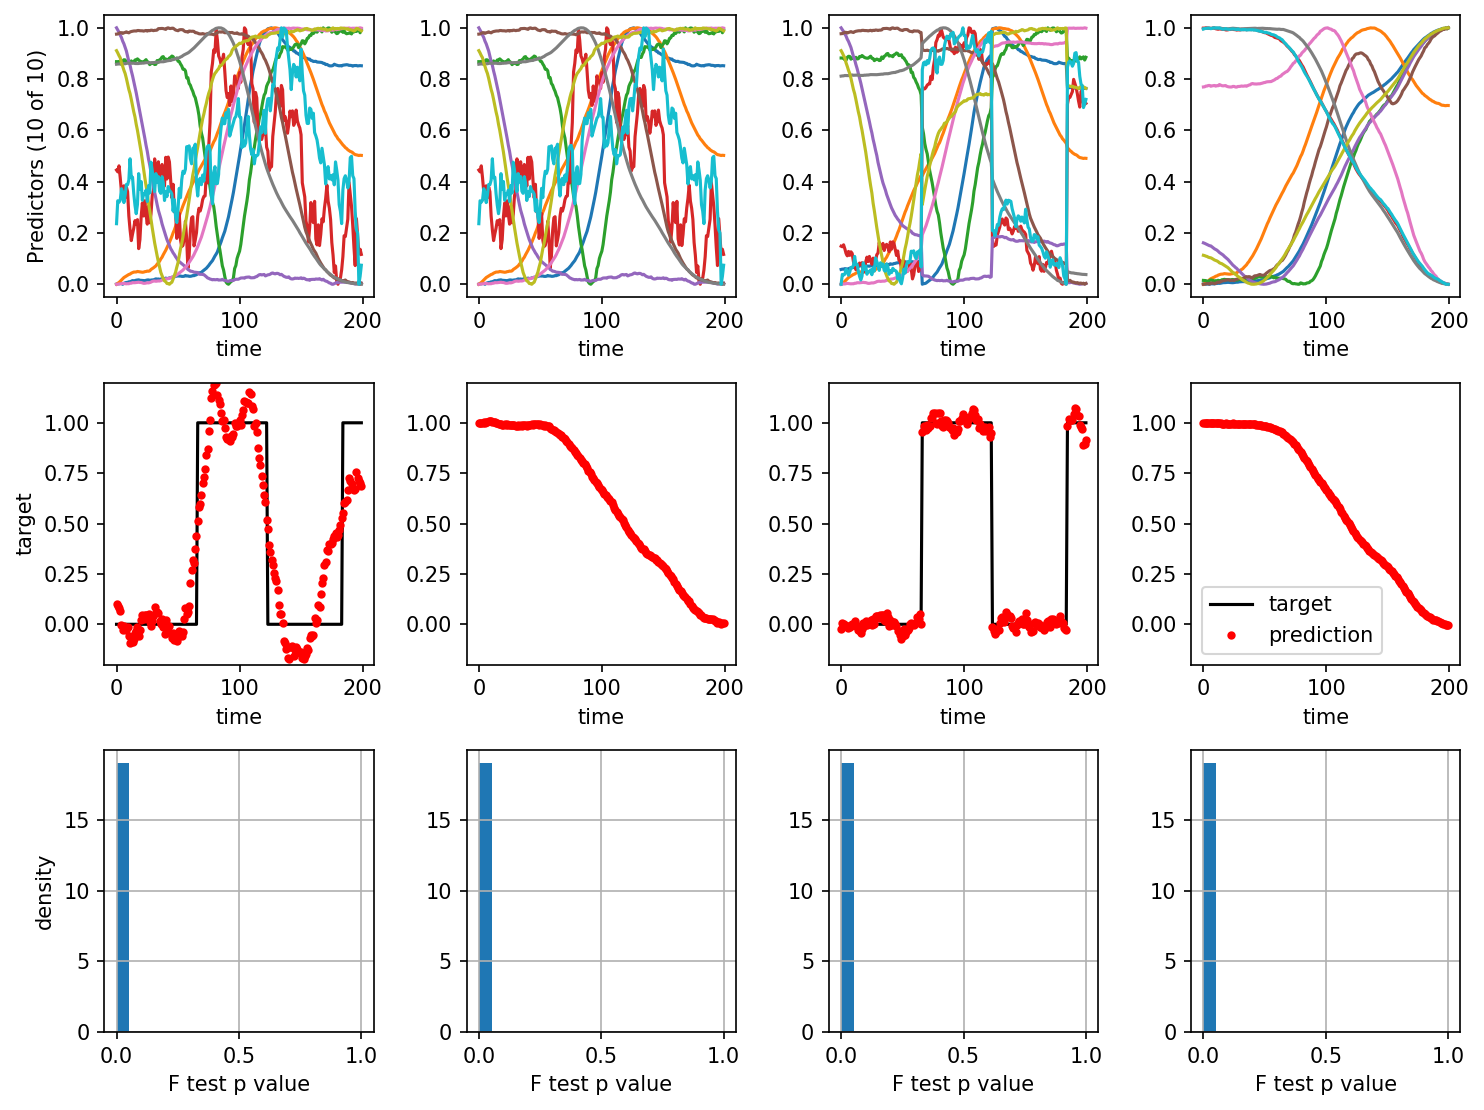

In [8]:
# p values for multiple linear regression

if 1: # make 0 to skip calculations
    p_naive = np.zeros((n_params, R))
    for i in range(n_params):
        for r in range(R):
            x, y = test_data[i][r]
            model = sm.OLS(y,np.hstack((x,np.ones((params.T, 1))))).fit()  # Ordinary Least Squares
            p_naive[i, r] = model.f_pvalue
        
fig, ax = plt.subplots(3, n_params, figsize=(10, 7.5), dpi=150)
for i in range(n_params):
    x, y = test_data[i][0]
    ax[0, i].plot(x[:, :])
    ax[1, i].plot(y, 'k')
    _, _, y_hat = ridge_error(x, y)
    ax[1, i].plot(y_hat, 'r.')
    ax[1, i].set_ylim([-.2, 1.2])
    ax[2, i].hist(p_naive[i], np.linspace(0, 1, 20), density=True)

    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('time')
    ax[2, i].set_xlabel('F test p value')
    
ax[0, 0].set_ylabel(f'Predictors (10 of {params.C})')
ax[1, 0].set_ylabel('target')
ax[2, 0].set_ylabel('density')
ax[1, 3].legend(('target', 'prediction'))

plt.tight_layout()
if SaveFigs: 
    plt.savefig('Ftest.png', dpi=300)

p_value = 0.762
p_value = 0.7979999999999999
p_value = 0.0
p_value = 0.522


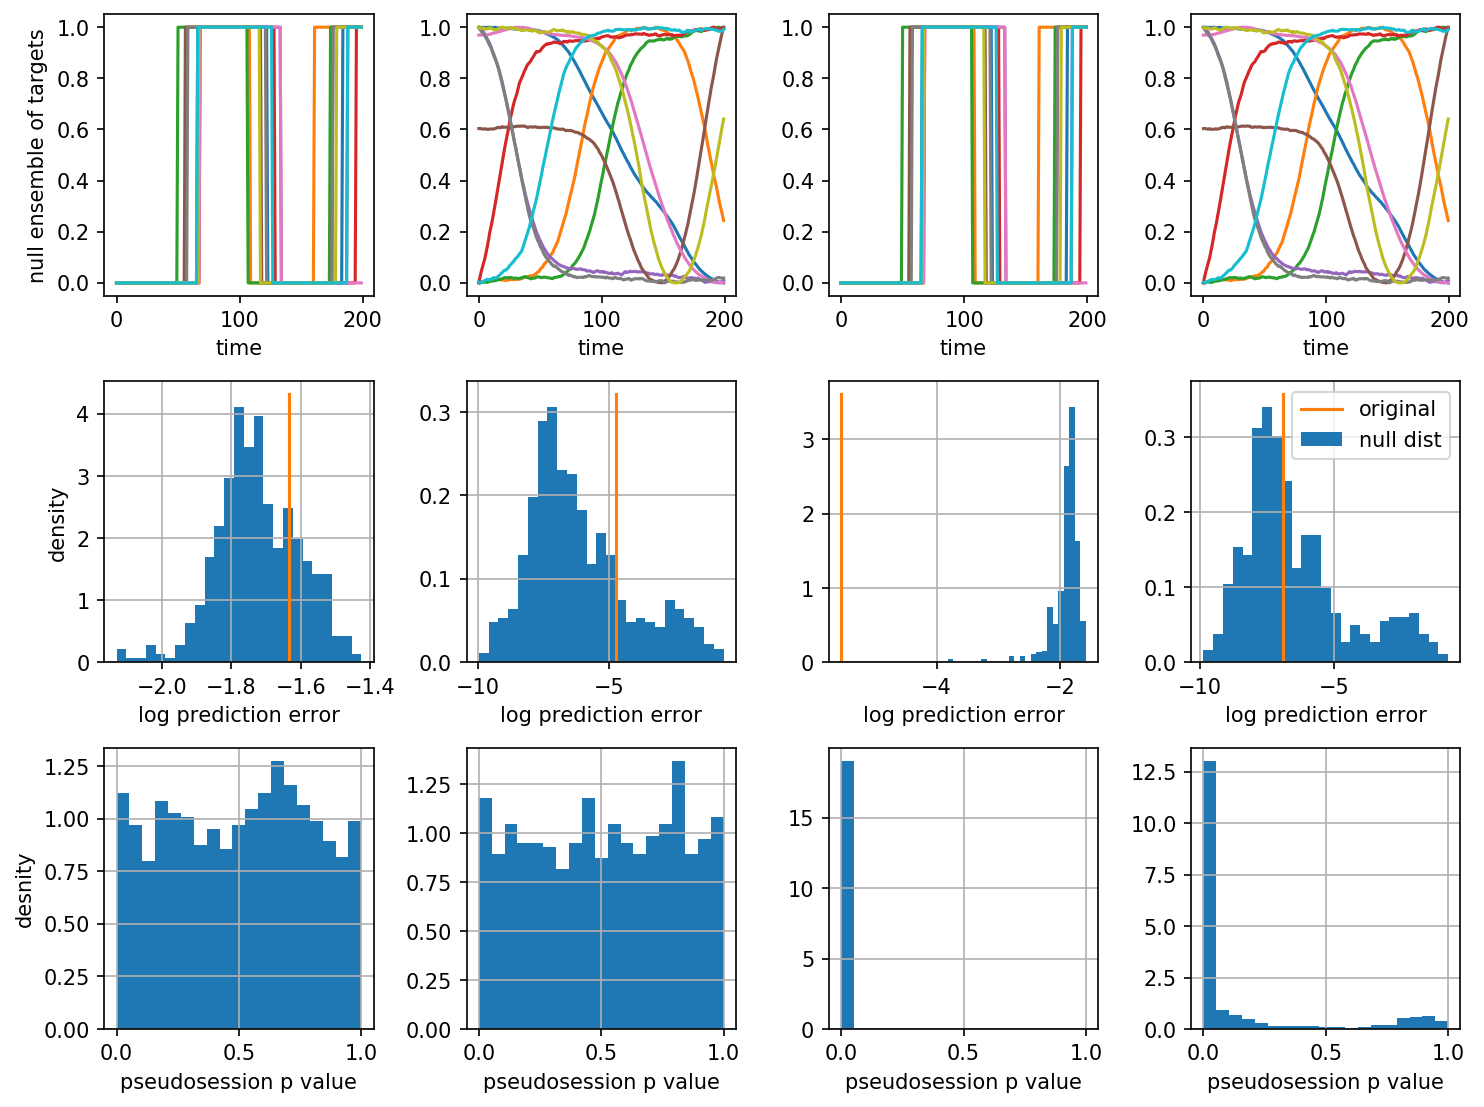

In [9]:
# pseudosession method

if 1: # make 0 to skip calculations
    p_pseudosession = np.zeros((n_params, R))
    pScore_pseud = np.zeros((n_params, N))
    uScore_pseud = np.zeros(n_params)
    for i, params in enumerate(param_list):
        np.random.seed(seed)
        for r in range(R):
            x, y = test_data[i][r]
            uScore_pseud[i], _, _ = ridge_error(x, y) # unpermuted score

            for n in range(N):
                _, y2 = make_data(params)
                pScore_pseud[i, n], _, _ = ridge_error(x, y2)
            # compare the percentile rank of uScore_pseud against the pScore_pseud array
            p_pseudosession[i, r] = stats.percentileofscore(pScore_pseud[i], uScore_pseud[i])/100  

fig, ax = plt.subplots(3, n_params, figsize=(10,7.5), dpi=150)#, sharey='row')
for i, params in enumerate(param_list):
    np.random.seed(seed)
    for n in range(10): 
        _, y2 = make_data(params)
        ax[0, i].plot(y2)
    ax[1, i].hist(np.log(pScore_pseud[i]), 25, density=True)
    ax[1, i].plot(np.full(2, np.log(uScore_pseud[i])), ax[1, i].get_ylim())
    ax[1, i].grid()

    print(f'p_value = {p_pseudosession[i, -1]}')
    ax[2, i].hist(p_pseudosession[i], np.linspace(0,1,20), density=True)
    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('log prediction error')
    ax[2, i].set_xlabel('pseudosession p value')
        
ax[0, 0].set_ylabel('null ensemble of targets')
ax[1, 0].set_ylabel('frequency')
ax[1, 0].set_ylabel('density')
ax[2, 0].set_ylabel('desnity')
ax[1, 3].legend(['original', 'null dist'])
    
plt.tight_layout()
if SaveFigs: plt.savefig('Pseudosession.png', dpi=300)

data set 0
data set 1
data set 2
data set 3


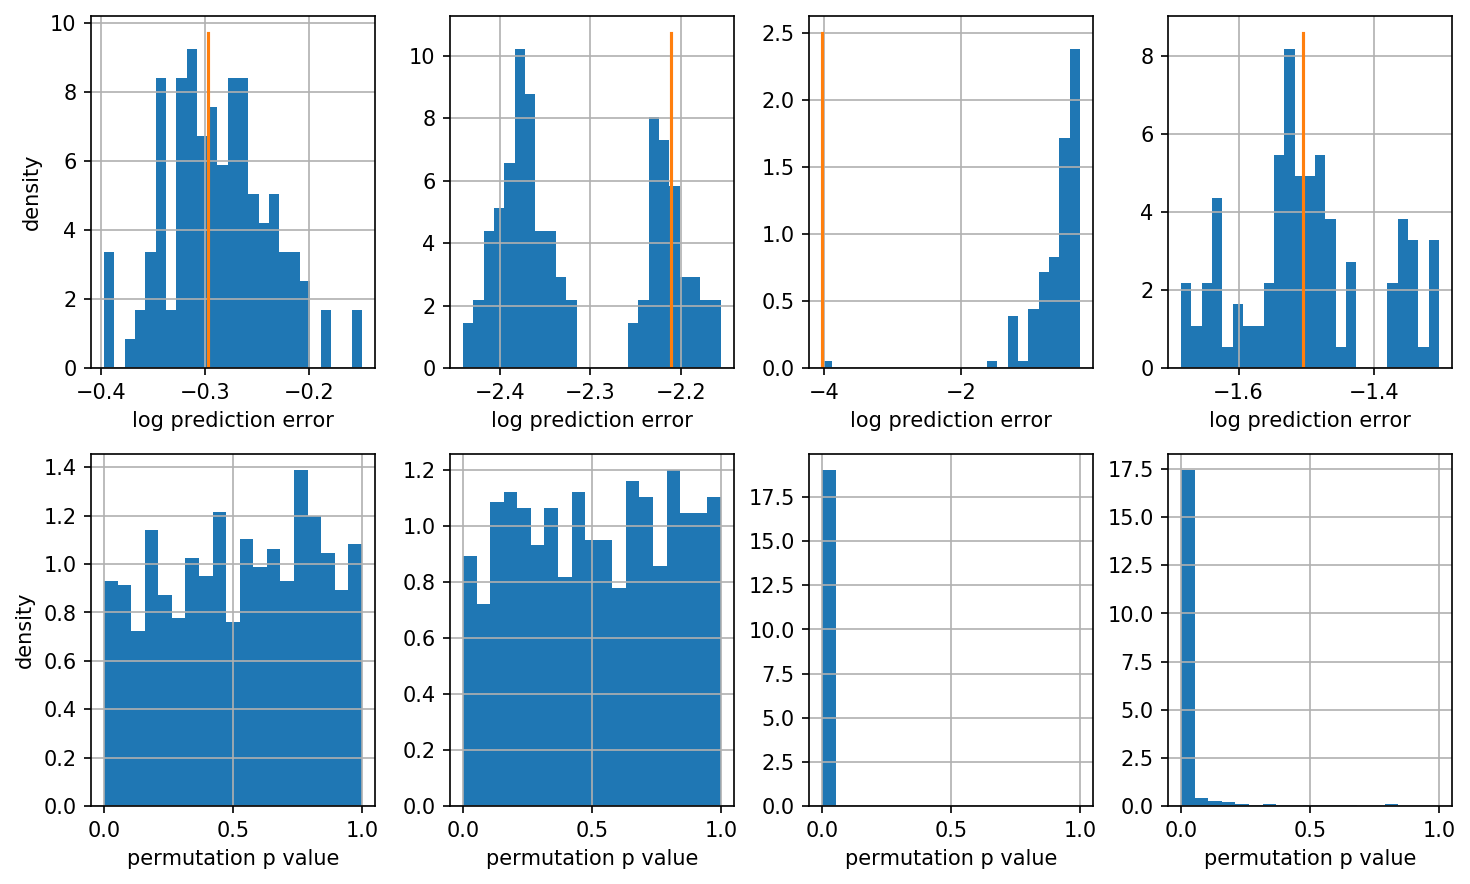

In [10]:
# Session permutation
S = 5 # number of sessions

if 1: # make 0 to skip calculations
    np.random.seed(seed)
        
    p_perm = np.zeros((n_params, R))
    uScore_perm = np.zeros(n_params)
    pScore_perm = np.zeros((n_params, np.math.factorial(S)))

    for i, params in enumerate(param_list):
        print(f'data set {i}')
        for r in range(R):
            x = np.empty(S, dtype=object)
            y = np.empty(S, dtype=object)

            uScore_perm[i] = 0
            for s in range(S):
                x[s], y[s] = make_data(params)
                sc, _, _ = ridge_error(x[s], y[s], 0)
                uScore_perm[i] += sc

            pScore_perm[i] = 0
            for j, p in enumerate(itertools.permutations(range(S))):
                for s in range(S):
                    sc, _, _ = ridge_error(x[s], y[p[s]], 0)
                    pScore_perm[i, j] += sc

            p_perm[i, r] = stats.percentileofscore(pScore_perm[i], uScore_perm[i])/100
        
fig, ax = plt.subplots(2,len(param_list), figsize=(10,6), dpi=150)
for i in range(n_params):
    ax[0, i].hist(np.log(pScore_perm[i]), 25, density=True)
    ax[0, i].plot(np.full(2,np.log(uScore_perm[i])), ax[0,i].get_ylim())
    ax[0, i].grid()
    ax[1, i].hist(p_perm[i],np.linspace(0,1,20), density=True)
    ax[1, i].grid()
    ax[0, i].set_xlabel('log prediction error')
    ax[1, i].set_xlabel('permutation p value')


ax[0, 0].set_ylabel('density')
ax[1, 0].set_ylabel('density')

plt.tight_layout()
if SaveFigs: plt.savefig('SessionPerm.png', dpi=300)

# Simulation

## random walk neurons vs. value from foraging

In [3]:
def gen_random_walk_neuron(n_trial, diff_para=0.1, f_1=2.5, 
                           seed=None, plot=False):
    if seed:
        np.random.seed(seed)

    firing_rate = np.zeros(n_trial)
    firing_rate[0] = np.random.uniform(f_1-0.1, f_1+0.1)
    for i in range(1, n_trial):
        firing_rate[i] = max((0, firing_rate[i-1]+np.random.normal(loc=0, scale=diff_para, size=1)))
    
    if plot:
        plt.plot(firing_rate)

    return firing_rate


def gen_action_value_neuron(qs, k_max_modulation=2.35, f_baseline=2.5, 
                            seed=None, plot=False):
    if seed:
        np.random.seed(seed)
    
    r_neuron_modulation = np.random.uniform(low=-1.0, high=1.0, size=1)
    firing_rate = f_baseline + k_max_modulation * r_neuron_modulation * qs
    spike_cts = np.random.poisson(lam=firing_rate)
    
    if plot:
        plt.plot(spike_cts)

    return spike_cts

In [4]:
subject_id = 482353
model_id = 10
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable 
                    & {'subject_id': subject_id, 
                       'model_id': model_id})

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

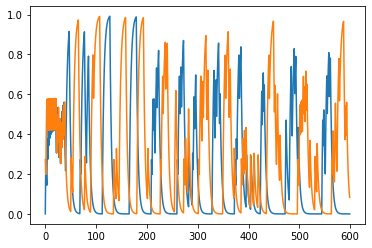

In [51]:
plt.plot(df_Qs[df_Qs['session']==1]['Q_left'].values)
plt.plot(df_Qs[df_Qs['session']==1]['Q_right'].values)

In [5]:
# select sessions
sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

n_session_to_ana = 5
manual_selection = True
if manual_selection:
    sessions = [38, 39, 40, 42, 45]
else:
    sessions = np.random.choice(sessions_all, size=n_session_to_ana)
print(f'selected sessions for ana: {sessions}')

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
selected sessions for ana: [38, 39, 40, 42, 45]


In [53]:
# generate simulated neurons
n_neurons = 2000
action_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])
rw_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])

for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    print(f'session {session}: {X.shape}')

    # action neurons
    for n in range(n_neurons):    
        q_side = random.choice(['Q_left', 'Q_right'])
        fr = gen_action_value_neuron(X[q_side].values)
        action_neurons.loc[len(action_neurons.index)] = [session, n, fr]

    # random walk neurons
    for n in range(n_neurons):
        fr = gen_random_walk_neuron(len(X))
        rw_neurons.loc[len(rw_neurons.index)] = [session, n, fr]

session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)


In [54]:
df_action_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])
df_rw_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])

# fit simulated neurons
for session in sessions:
    
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    X = sm.add_constant(X)
    print(f'session {session}: {X.shape}')

    for n in range(n_neurons):
        # action neurons
        fr = action_neurons[(action_neurons['session']==session) & (action_neurons['neuron_id']==n)]['firing_rates'].values[0]
        model = sm.OLS(fr, X)
        results = model.fit()
        df_action_neuron_fit.loc[len(df_action_neuron_fit.index)] = [session, n, session, results.tvalues, results.params]

    for n in range(n_neurons):
        # random walk neurons
        fr = rw_neurons[(action_neurons['session']==session) & (action_neurons['neuron_id']==n)]['firing_rates'].values[0]
        model = sm.OLS(fr, X)
        results = model.fit()
        df_rw_neuron_fit.loc[len(df_rw_neuron_fit.index)] = [session, n, session, results.tvalues, results.params]

session 38: (468, 3)
session 39: (594, 3)
session 40: (669, 3)
session 42: (1143, 3)
session 45: (635, 3)


check sum of dots: 10000
10000.0
3294
3169
217
97
check sum of dots: 10000
10000.0
2280
2276
1607
520


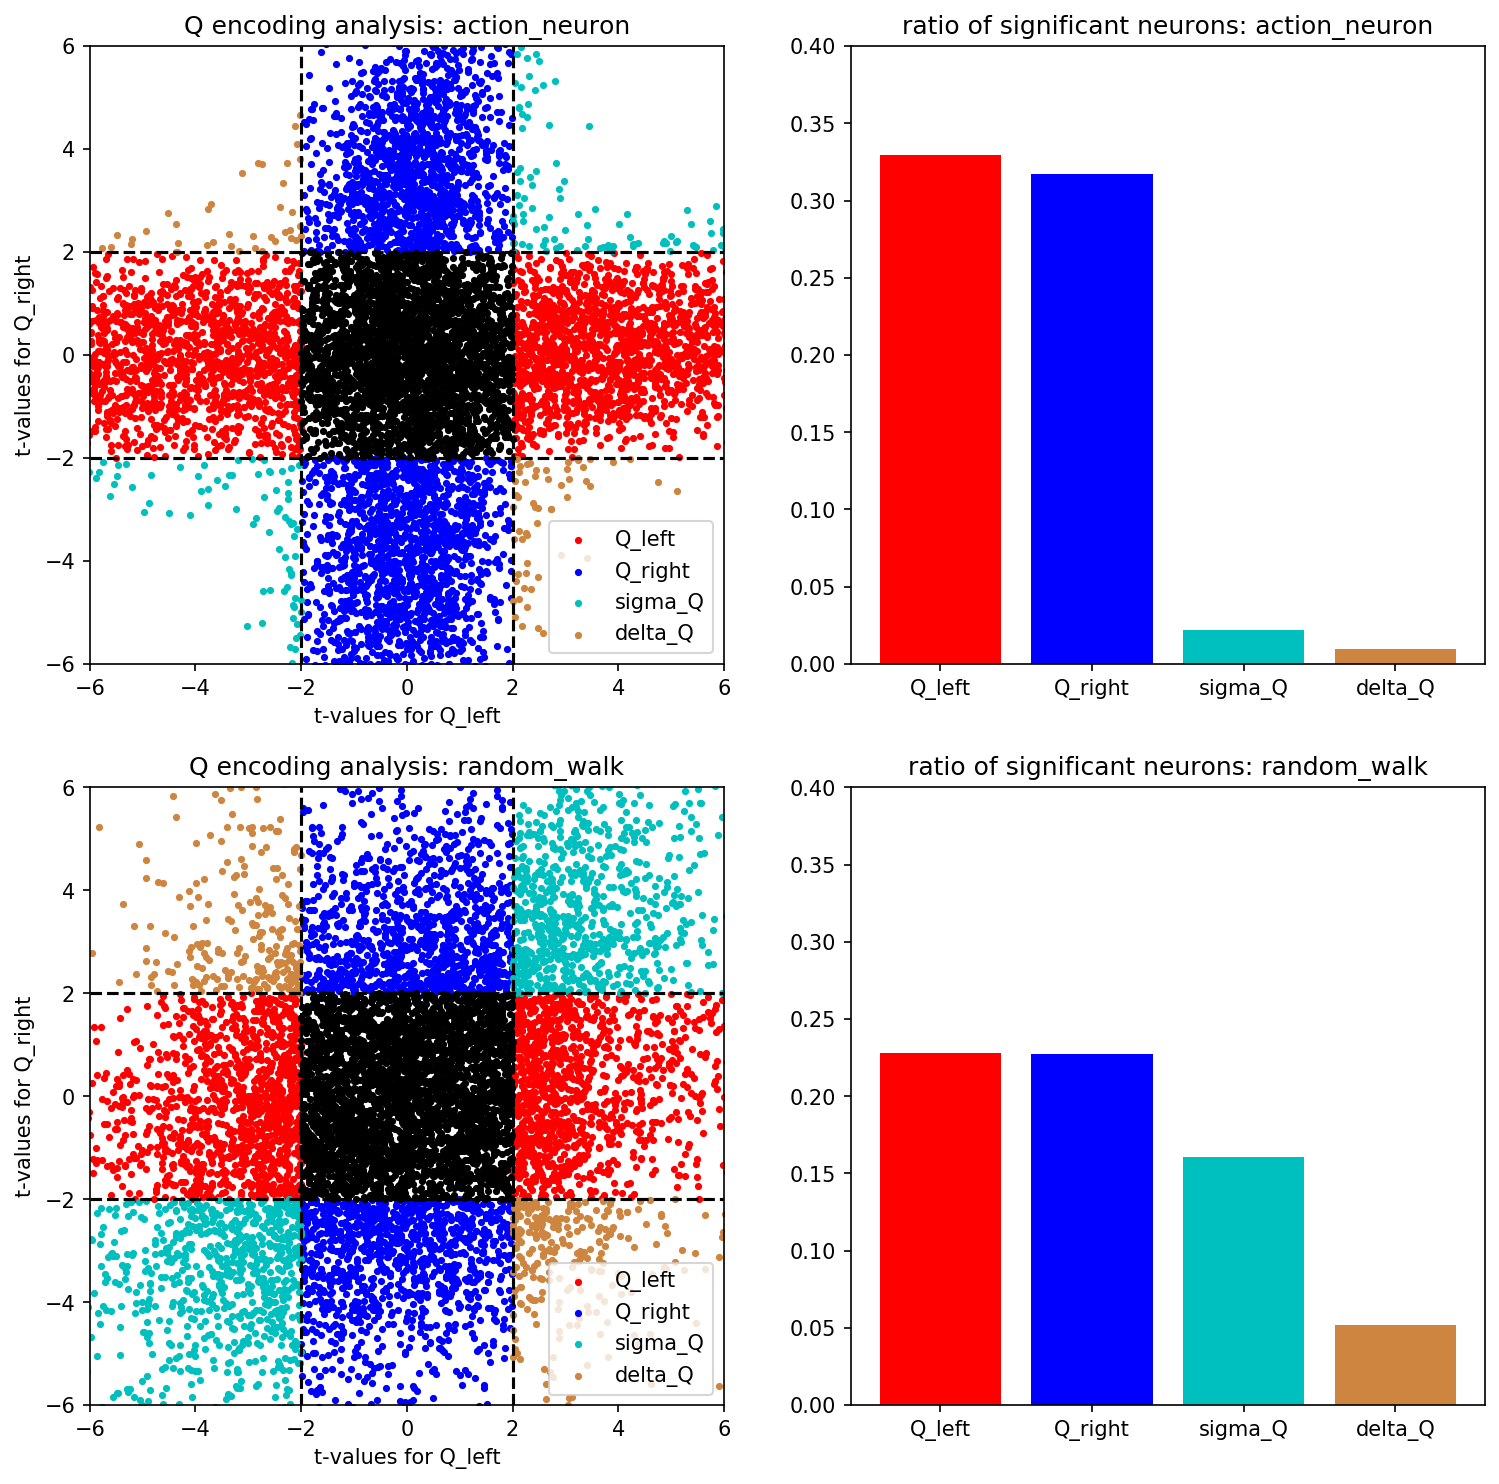

In [55]:
df_t_values_dict = {
    'action_neuron': pd.DataFrame(df_action_neuron_fit['tvalues'].values.tolist(), index=df_action_neuron_fit['tvalues'].index),
    'random_walk': pd.DataFrame(df_rw_neuron_fit['tvalues'].values.tolist(), index=df_rw_neuron_fit['tvalues'].index)
}

colors = ['r', 'b', 'c', 'peru']
dot_size = 6

neuron_types = ['action_neuron', 'random_walk']

fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=150)
for i, neuron_type in enumerate(neuron_types):
    df_t_values = df_t_values_dict[neuron_type]

    df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=2) & (abs(df_t_values['Q_right'])<2)]
    axs[i, 0].scatter(df_t_Q_left['Q_left'].values, df_t_Q_left['Q_right'].values, 
                      color='r', s=dot_size, label='Q_left')
    df_t_Q_right = df_t_values[(abs(df_t_values['Q_right'])>=2) & (abs(df_t_values['Q_left'])<2)]
    axs[i, 0].scatter(df_t_Q_right['Q_left'].values, df_t_Q_right['Q_right'].values, 
                      color='b', s=dot_size, label='Q_right')
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
    axs[i, 0].scatter(df_t_sigma_Q['Q_left'].values, df_t_sigma_Q['Q_right'].values, 
                      color='c', s=dot_size, label='sigma_Q')
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
    axs[i, 0].scatter(df_t_delta_Q['Q_left'].values, df_t_delta_Q['Q_right'].values, 
                      color='peru', s=dot_size, label='delta_Q')
    df_t_null = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])<2)]
    axs[i, 0].scatter(df_t_null['Q_left'].values, df_t_null['Q_right'].values, 
                      color='k', s=dot_size)

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    axs[i, 0].axhline(-2, color='k', linestyle='--')
    axs[i, 0].axhline(2, color='k', linestyle='--')
    axs[i, 0].axvline(-2, color='k', linestyle='--')
    axs[i, 0].axvline(2, color='k', linestyle='--')

    axs[i, 0].set_title(f'Q encoding analysis: {neuron_type}')
    axs[i, 0].set_xlim(-6, 6)
    axs[i, 0].set_ylim(-6, 6)
    axs[i, 0].set_xlabel('t-values for Q_left')
    axs[i, 0].set_ylabel('t-values for Q_right')
    axs[i, 0].legend()


    names = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
    print(float(len(df_t_values)))
    print(len(df_t_Q_left))
    print(len(df_t_Q_right))
    print(len(df_t_sigma_Q))
    print(len(df_t_delta_Q))
    values = [
        len(df_t_Q_left)/ float(len(df_t_values)),
        len(df_t_Q_right)/ float(len(df_t_values)),
        len(df_t_sigma_Q)/ float(len(df_t_values)),
        len(df_t_delta_Q)/ float(len(df_t_values))
    ]
    axs[i, 1].bar(names, values, color=colors)
    x_lim = axs[i, 1].get_xlim()
    axs[i, 2].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[i, 1].set_title(f'ratio of significant neurons: {neuron_type}')
    axs[i, 1].set_ylim(0, 0.4)


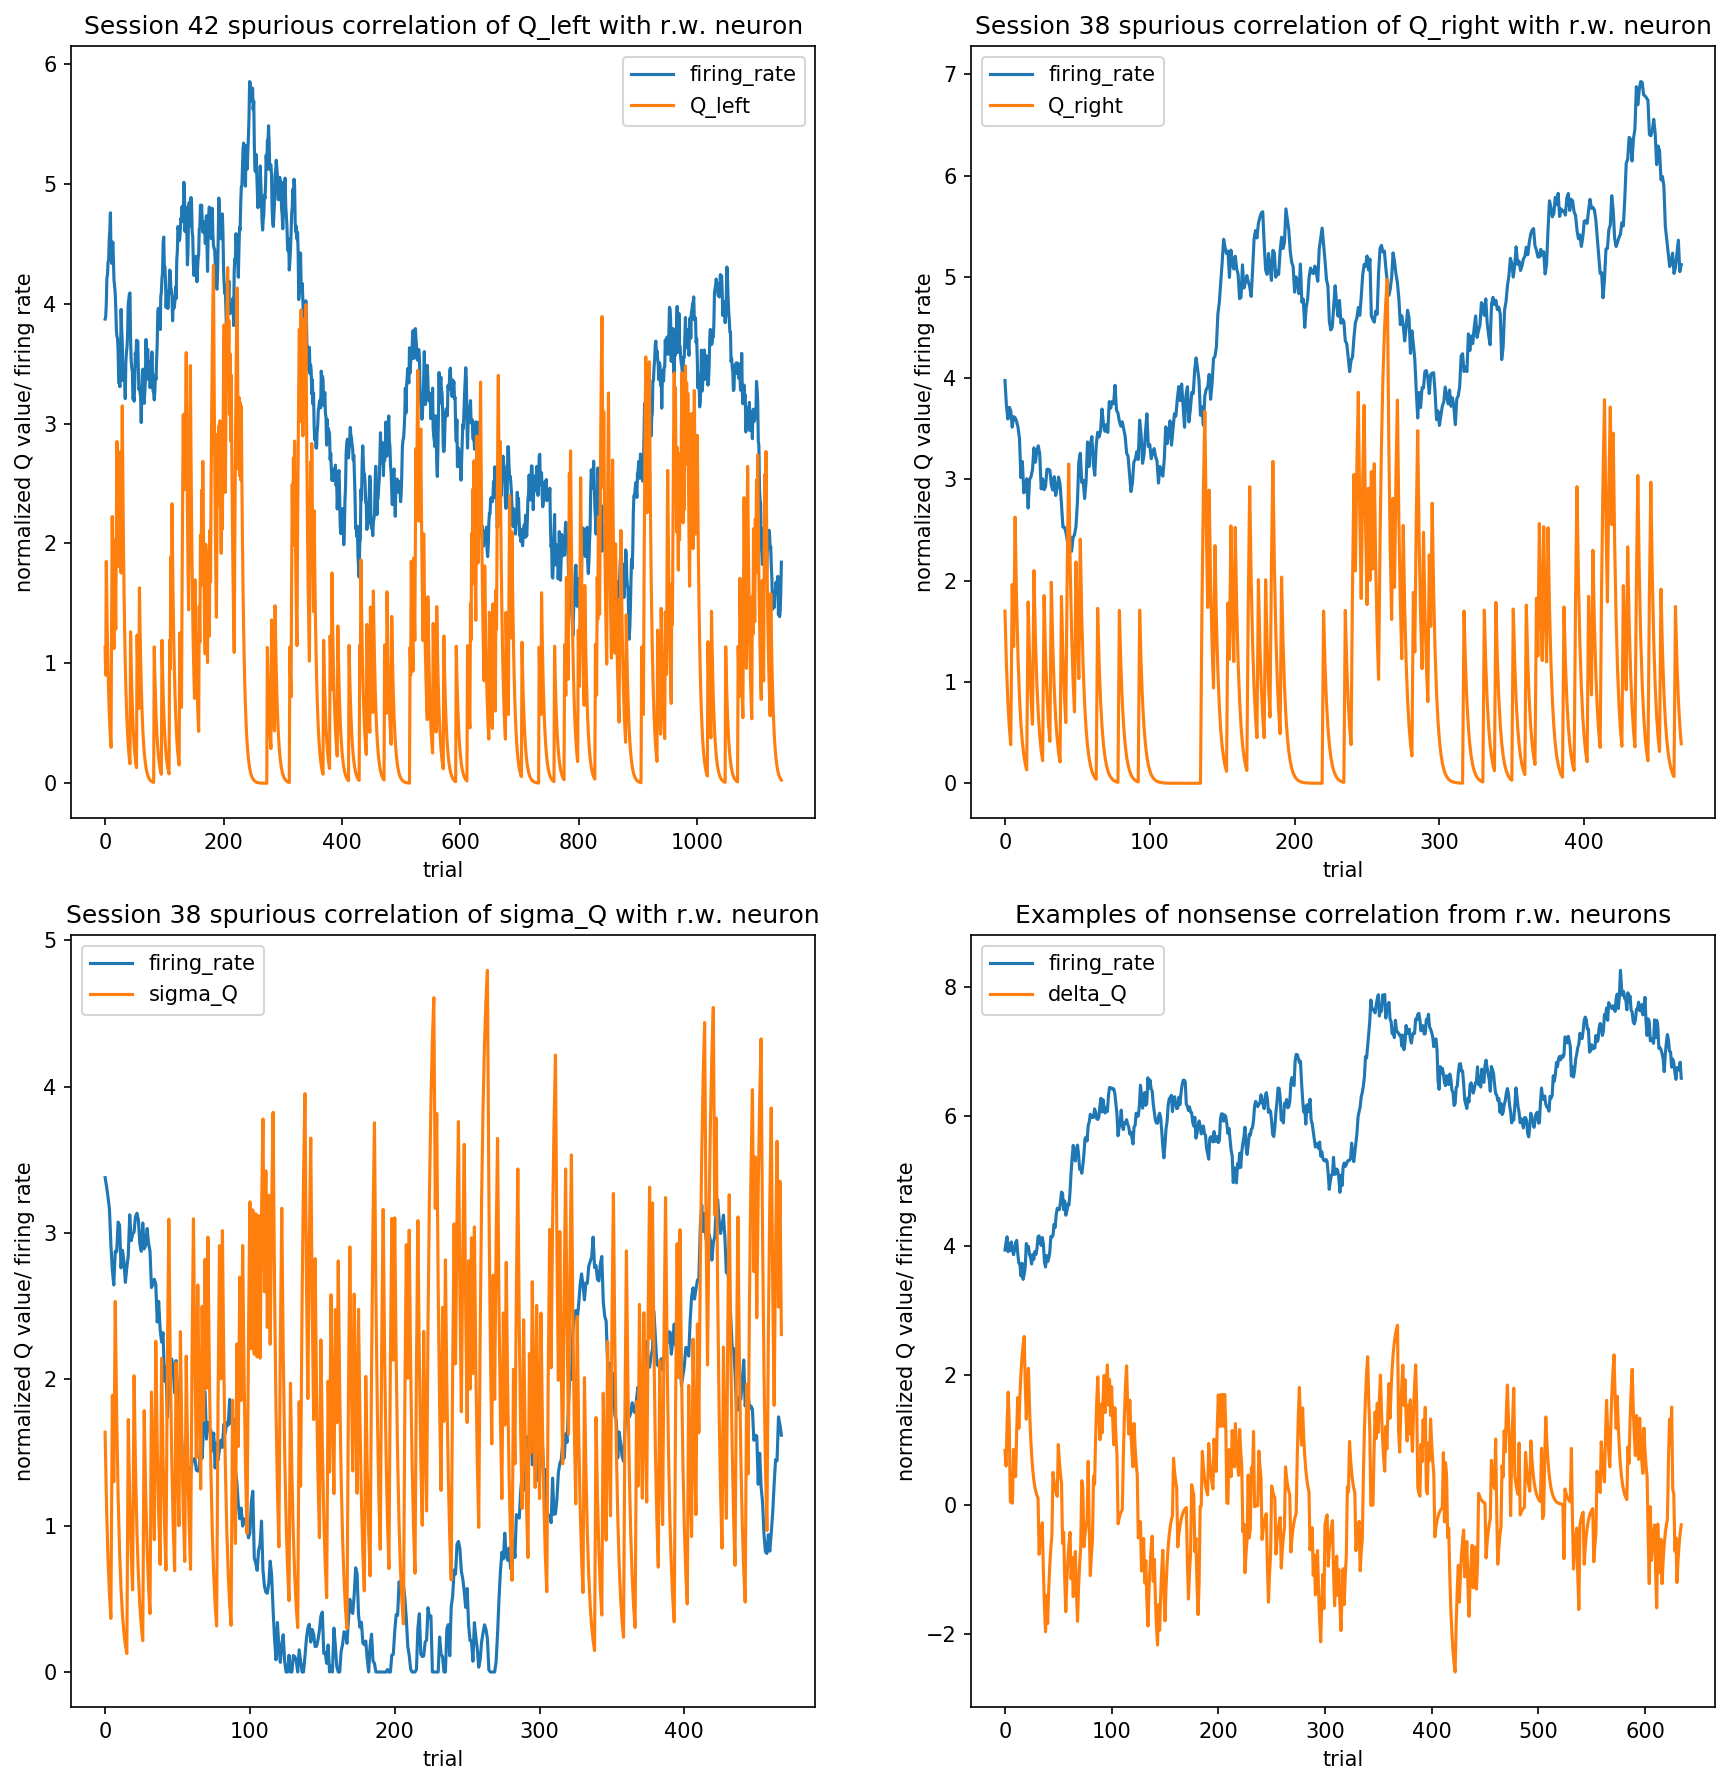

In [57]:
# plot example neurons 
plot_threshold = 3
neuron_type = 'random_walk'
df_t_values = df_t_values_dict[neuron_type]

def ax_plot_normalized_traces(ax, fr, qs, q_type, session):
    '''
    q_type: 'Q_left', 'Q_right', 'sigma_Q', 'delta_Q'
    '''
    fr_normalized = fr/ np.std(fr)
    qs_normalized = qs/ np.std(qs)
    ax.plot(fr_normalized, label='firing_rate')
    ax.plot(qs_normalized, label=q_type)

    ax.set_title(f'Session {session} spurious correlation of {q_type} with r.w. neuron')
    ax.set_xlabel('trial')
    ax.set_ylabel('normalized Q value/ firing rate')
    ax.legend(loc='best')

    return ax


fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=150)
# Q_left neuron example
df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=plot_threshold) & (abs(df_t_values['Q_right'])<2)]
Q_left_ind = np.random.choice(df_t_Q_left.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[Q_left_ind]
session = rw_neurons.iloc[Q_left_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_left'].values
axs[0, 0] = ax_plot_normalized_traces(axs[0, 0], fr, qs, 'Q_left', session)

# Q_right neuron example
df_t_Q_right = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])>=plot_threshold)]
Q_right_ind = np.random.choice(df_t_Q_right.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[Q_right_ind]
session = rw_neurons.iloc[Q_right_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_right'].values
axs[0, 1] = ax_plot_normalized_traces(axs[0, 1], fr, qs, 'Q_right', session)

# sigma_Q neuron example
df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
sigma_Q_ind = np.random.choice(df_t_sigma_Q.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[sigma_Q_ind]
session = rw_neurons.iloc[sigma_Q_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_left'].values + df_Qs[df_Qs['session']==session]['Q_right'].values
axs[1, 0] = ax_plot_normalized_traces(axs[1, 0], fr, qs, 'sigma_Q', session)

# delta_Q neuron example
df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
delta_Q_ind = np.random.choice(df_t_delta_Q.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[delta_Q_ind]
session = rw_neurons.iloc[delta_Q_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_left'].values - df_Qs[df_Qs['session']==session]['Q_right'].values
axs[1, 1] = ax_plot_normalized_traces(axs[1, 1], fr, qs, 'delta_Q', session)

plt.title('Examples of nonsense correlation from r.w. neurons')
plt.tight_layout()

In [59]:
# bootstrp for effect of diffusion parameter
n_neurons = 1000
diff_paras = [0, 0.0001, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
diff_para_fit = {}

for diff_para in diff_paras:
    print(f'diffuson parameter: {diff_para}')
    random_walk_fit = {'fr': [], 'params': [], 't_values': []}
    for session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        X = sm.add_constant(X)
        print(f' session {session}: {X.shape}')

        for n in range(n_neurons):
            # random walk neurons
            fr = gen_random_walk_neuron(len(X), diff_para=diff_para)
            model = sm.OLS(fr, X)
            results = model.fit()
            random_walk_fit['fr'].append(fr)
            random_walk_fit['params'].append(results.params)
            random_walk_fit['t_values'].append(results.tvalues)
        plt.show()
        plt.close()
    diff_para_fit[diff_para] = random_walk_fit

diffuson parameter: 0
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.0001
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.025
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.05
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.075
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.1
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.125
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.15
 session 38: (468, 3)


In [60]:
ratio_single_significant_values = []
ratio_double_significant_values = []

for diff_para in diff_paras:
    print(f'diff para: {diff_para}')
    df_t_values = pd.DataFrame(diff_para_fit[diff_para]['t_values'])

    df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=2) & (abs(df_t_values['Q_right'])<2)]
    df_t_Q_right = df_t_values[(abs(df_t_values['Q_right'])>=2) & (abs(df_t_values['Q_left'])<2)]
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
    df_t_null = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])<2)]

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    ratio_single_significant_values.append((len(df_t_Q_left)+len(df_t_Q_right))/ float(len(df_t_values)))
    ratio_double_significant_values.append((len(df_t_sigma_Q)+len(df_t_delta_Q))/ float(len(df_t_values)))

diff para: 0
check sum of dots: 4998
diff para: 0.0001
check sum of dots: 5000
diff para: 0.025
check sum of dots: 5000
diff para: 0.05
check sum of dots: 5000
diff para: 0.075
check sum of dots: 5000
diff para: 0.1
check sum of dots: 5000
diff para: 0.125
check sum of dots: 5000
diff para: 0.15
check sum of dots: 5000
diff para: 0.175
check sum of dots: 5000
diff para: 0.2
check sum of dots: 5000


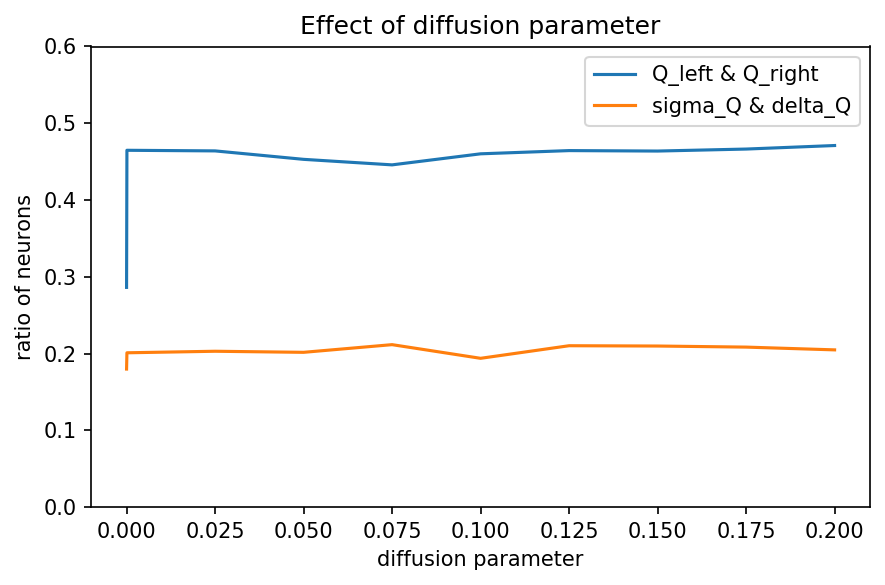

In [61]:
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(diff_paras, ratio_single_significant_values, label='Q_left & Q_right')
plt.plot(diff_paras, ratio_double_significant_values, label='sigma_Q & delta_Q')
plt.title('Effect of diffusion parameter')
plt.ylabel('ratio of neurons')
plt.xlabel('diffusion parameter')
plt.ylim(0, 0.6)
plt.legend()
plt.tight_layout()

## Session permutation

### naive permutation method
- comment: needs lager session numbers

In [62]:

sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

session_len = []
for sess in sessions_all:
    df_Qs_session = df_Qs[df_Qs['session']==sess].sort_values(by=['trial'])
    session_len.append(len(df_Qs_session))

print(f'min session {session_len.index(min(session_len))} len: {min(session_len)}, max session {session_len.index(max(session_len))} len: {max(session_len)}')

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
min session 34 len: 181, max session 41 len: 1143


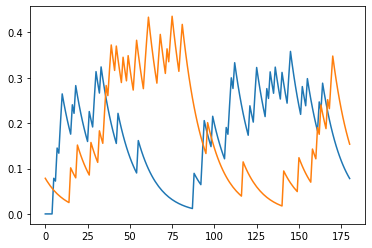

In [63]:
# check the shortest trial
plot_ind = session_len.index(min(session_len))
plt.plot(df_Qs[df_Qs['session']==sessions_all[plot_ind]]['Q_left'].values)
plt.plot(df_Qs[df_Qs['session']==sessions_all[plot_ind]]['Q_right'].values)

In [111]:
# generate simulated neurons
n_neurons = 10
action_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])
rw_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])

# use all sessions
sessions = sessions_all
len_min = min(session_len)

for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    print(f'session {session}: {X.shape}')

    # chop the session to chunks of min len
    for i in range(int(np.floor(len(df_Qs_session)/ len_min))):
        t_start = i * len_min

        if i == 0: # remove this to treat different chunks as different sessions
            # action neurons
            for n in range(n_neurons):    
                q_side = random.choice(['Q_left', 'Q_right'])
                fr = gen_action_value_neuron(X[q_side].values[t_start: t_start+len_min])
                action_neurons.loc[len(action_neurons.index)] = [session, n, fr]
            
            # random walk neurons
            for n in range(n_neurons):
               fr = gen_random_walk_neuron(len_min)
               rw_neurons.loc[len(rw_neurons.index)] = [session, n, fr]

session 1: (600, 2)
session 2: (411, 2)
session 3: (512, 2)
session 4: (620, 2)
session 5: (1056, 2)
session 6: (787, 2)
session 7: (936, 2)
session 8: (728, 2)
session 9: (804, 2)
session 10: (703, 2)
session 11: (798, 2)
session 12: (786, 2)
session 13: (791, 2)
session 14: (812, 2)
session 15: (725, 2)
session 16: (840, 2)
session 17: (743, 2)
session 18: (407, 2)
session 19: (639, 2)
session 20: (707, 2)
session 21: (660, 2)
session 22: (722, 2)
session 23: (696, 2)
session 24: (484, 2)
session 25: (606, 2)
session 26: (824, 2)
session 27: (520, 2)
session 28: (751, 2)
session 29: (811, 2)
session 30: (650, 2)
session 31: (581, 2)
session 32: (574, 2)
session 33: (586, 2)
session 34: (379, 2)
session 35: (181, 2)
session 36: (450, 2)
session 37: (321, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 41: (891, 2)
session 42: (1143, 2)
session 43: (792, 2)
session 44: (249, 2)
session 45: (635, 2)


In [128]:
# compute the t-values of the regression coefficients 
# of the spike counts on each of the estimated action-values 
# in all possible sessions

df_action_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])
df_rw_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])

# fit simulated neurons
for fit_session in sessions:
    
    df_Qs_session = df_Qs[df_Qs['session']==fit_session].sort_values(by=['trial'])
    X_fit = df_Qs_session[['Q_left', 'Q_right']]
    X_fit = sm.add_constant(X_fit)
    X_fit = X_fit[:len_min]
    print(f'session {fit_session}: {X_fit.shape}')

    for n in range(n_neurons):
        for gen_session in sessions:
            # action neurons
            fr = action_neurons[(action_neurons['session']==gen_session) & (action_neurons['neuron_id']==n)]['firing_rates'].values[0]
            model = sm.OLS(fr, X_fit)
            results = model.fit()
            df_action_neuron_fit.loc[len(df_action_neuron_fit.index)] = [gen_session, n, fit_session, results.tvalues, results.params]

            # random walk neurons
            fr = rw_neurons[(rw_neurons['session']==gen_session) & (rw_neurons['neuron_id']==n)]['firing_rates'].values[0]
            model = sm.OLS(fr, X_fit)
            results = model.fit()
            df_rw_neuron_fit.loc[len(df_rw_neuron_fit.index)] = [gen_session, n, fit_session, results.tvalues, results.params]

session 1: (181, 3)
session 2: (181, 3)
session 3: (181, 3)
session 4: (181, 3)
session 5: (181, 3)
session 6: (181, 3)
session 7: (181, 3)
session 8: (181, 3)
session 9: (181, 3)
session 10: (181, 3)
session 11: (181, 3)
session 12: (181, 3)
session 13: (181, 3)
session 14: (181, 3)
session 15: (181, 3)
session 16: (181, 3)
session 17: (181, 3)
session 18: (181, 3)
session 19: (181, 3)
session 20: (181, 3)
session 21: (181, 3)
session 22: (181, 3)
session 23: (181, 3)
session 24: (181, 3)
session 25: (181, 3)
session 26: (181, 3)
session 27: (181, 3)
session 28: (181, 3)
session 29: (181, 3)
session 30: (181, 3)
session 31: (181, 3)
session 32: (181, 3)
session 33: (181, 3)
session 34: (181, 3)
session 35: (181, 3)
session 36: (181, 3)
session 37: (181, 3)
session 38: (181, 3)
session 39: (181, 3)
session 40: (181, 3)
session 41: (181, 3)
session 42: (181, 3)
session 43: (181, 3)
session 44: (181, 3)
session 45: (181, 3)


left percentile: [-1.99604204  2.26022251]
right percentile: [-1.39260371  1.60166697]
left percentile: [-6.38949012  4.80122044]
right percentile: [-4.4193147   4.75258586]


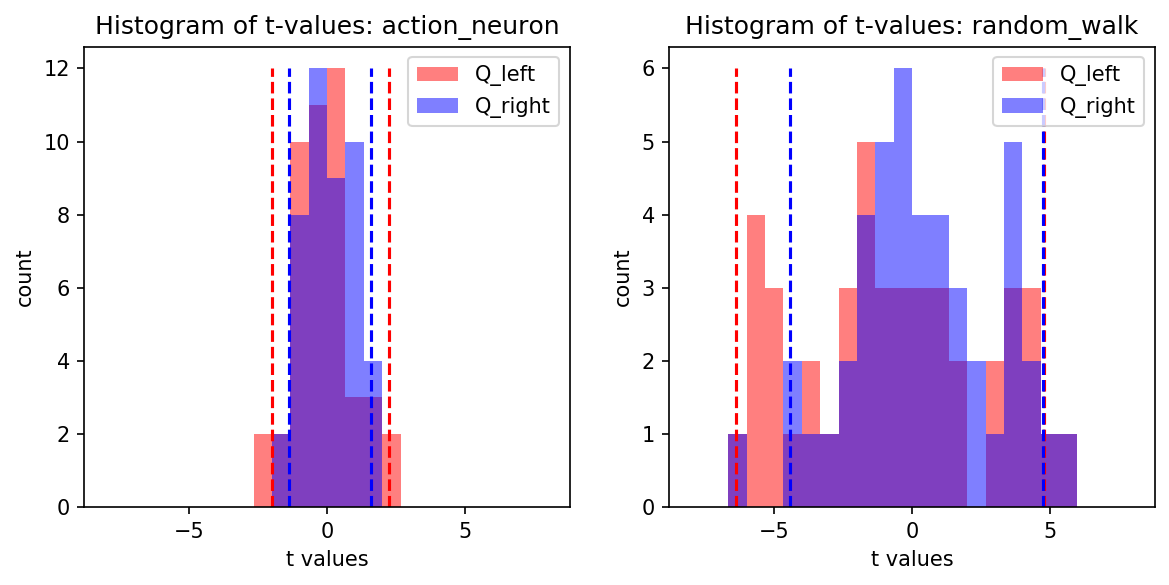

In [186]:
# get the 5% significance boundaries
session = 38
neuron_id = 3
#df_fit_session_neuron = df_action_neuron_fit[(df_action_neuron_fit['session']==session) & (df_action_neuron_fit['neuron_id']==neuron_id)]
#self_id = df_fit_session_neuron[df_fit_session_neuron['fit_session']==session].index[0]

'''
df_fit_session_neuron = df_action_neuron_fit
df_multisession_tvalue_session_neuron = pd.DataFrame(df_fit_session_neuron['tvalues'].values.tolist(), index=df_fit_session_neuron['tvalues'].index)
qs = df_multisession_tvalue_session_neuron['Q_right'].values
percentiles_2_compute = [5, 95]
q_percentiles = np.percentile(qs, percentiles_2_compute)
hist, bin, _ = plt.hist(qs, bins=32, range=(-4,4))
plt.vlines(q_percentiles, 0, np.max(hist))


df_fit_session_neuron = df_rw_neuron_fit[(df_rw_neuron_fit['session']==session) & (df_rw_neuron_fit['neuron_id']==neuron_id)]
#df_fit_session_neuron = df_rw_neuron_fit
df_multisession_tvalue_session_neuron = pd.DataFrame(df_fit_session_neuron['tvalues'].values.tolist(), index=df_fit_session_neuron['tvalues'].index)
qs = df_multisession_tvalue_session_neuron['Q_right'].values
percentiles_2_compute = [2.5, 97.5]
q_percentiles = np.percentile(qs, percentiles_2_compute)
hist, bin, _ = plt.hist(qs, bins=32, range=(-8,8))
plt.vlines(q_percentiles, 0, np.max(hist))
'''

plot_lim = (-8, 8)

df_fit_dict = {
    'action_neuron': df_action_neuron_fit,
    'random_walk': df_rw_neuron_fit
}

neuron_types = ['action_neuron', 'random_walk']

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
for i, neuron_type in enumerate(neuron_types):
    df_fit_session_neuron = df_fit_dict[neuron_type]
    # select the specified session
    df_fit_session_neuron = df_fit_session_neuron[(df_fit_session_neuron['session']==session) & (df_fit_session_neuron['neuron_id']==neuron_id)]
    df_t_values = pd.DataFrame(df_fit_session_neuron['tvalues'].values.tolist(), index=df_fit_session_neuron['tvalues'].index)
    
    # calculating percentiles
    t_left = df_t_values['Q_left'].values
    t_right = df_t_values['Q_right'].values
    percentiles_2_compute = [2.5, 97.5]
    t_left_percentile = np.percentile(t_left, percentiles_2_compute)
    t_right_percentile = np.percentile(t_right, percentiles_2_compute)
    print(f'left percentile: {t_left_percentile}')
    print(f'right percentile: {t_right_percentile}')
    
    plot_xlim = (np.floor(t_left_percentile[0]), np.floor(t_left_percentile[1])+1)
    plot_ylim = (np.floor(t_right_percentile[0]), np.floor(t_right_percentile[1])+1)
    hist_left, _, _ = axs[i].hist(t_left, bins=24, range=plot_lim, histtype='stepfilled', 
                                  color='r', label='Q_left', alpha=0.5)
    hist_right, _, _ = axs[i].hist(t_right, bins=24, range=plot_lim, histtype='stepfilled', 
                                   color='b', label='Q_right', alpha=0.5)
    axs[i].set_title(f'Histogram of t-values: {neuron_type}')
    axs[i].set_xlabel('t values')
    axs[i].set_ylabel('count')
    top = np.max(np.concatenate((hist_left, hist_right), axis=0))
    axs[i].vlines(t_left_percentile, 0, top, color='r', linestyle='--')
    axs[i].vlines(t_right_percentile, 0, top, color='b', linestyle='--')
    axs[i].legend(loc='best')
plt.tight_layout()

left percentile: [-2.10942405  2.11286758]
right percentile: [-2.07205918  2.09223766]
check sum of dots: 450
450.0
87
73
5
2
left percentile: [-6.43846303  6.45171904]
right percentile: [-5.71501679  5.82301667]
check sum of dots: 450
450.0
27
21
1
1


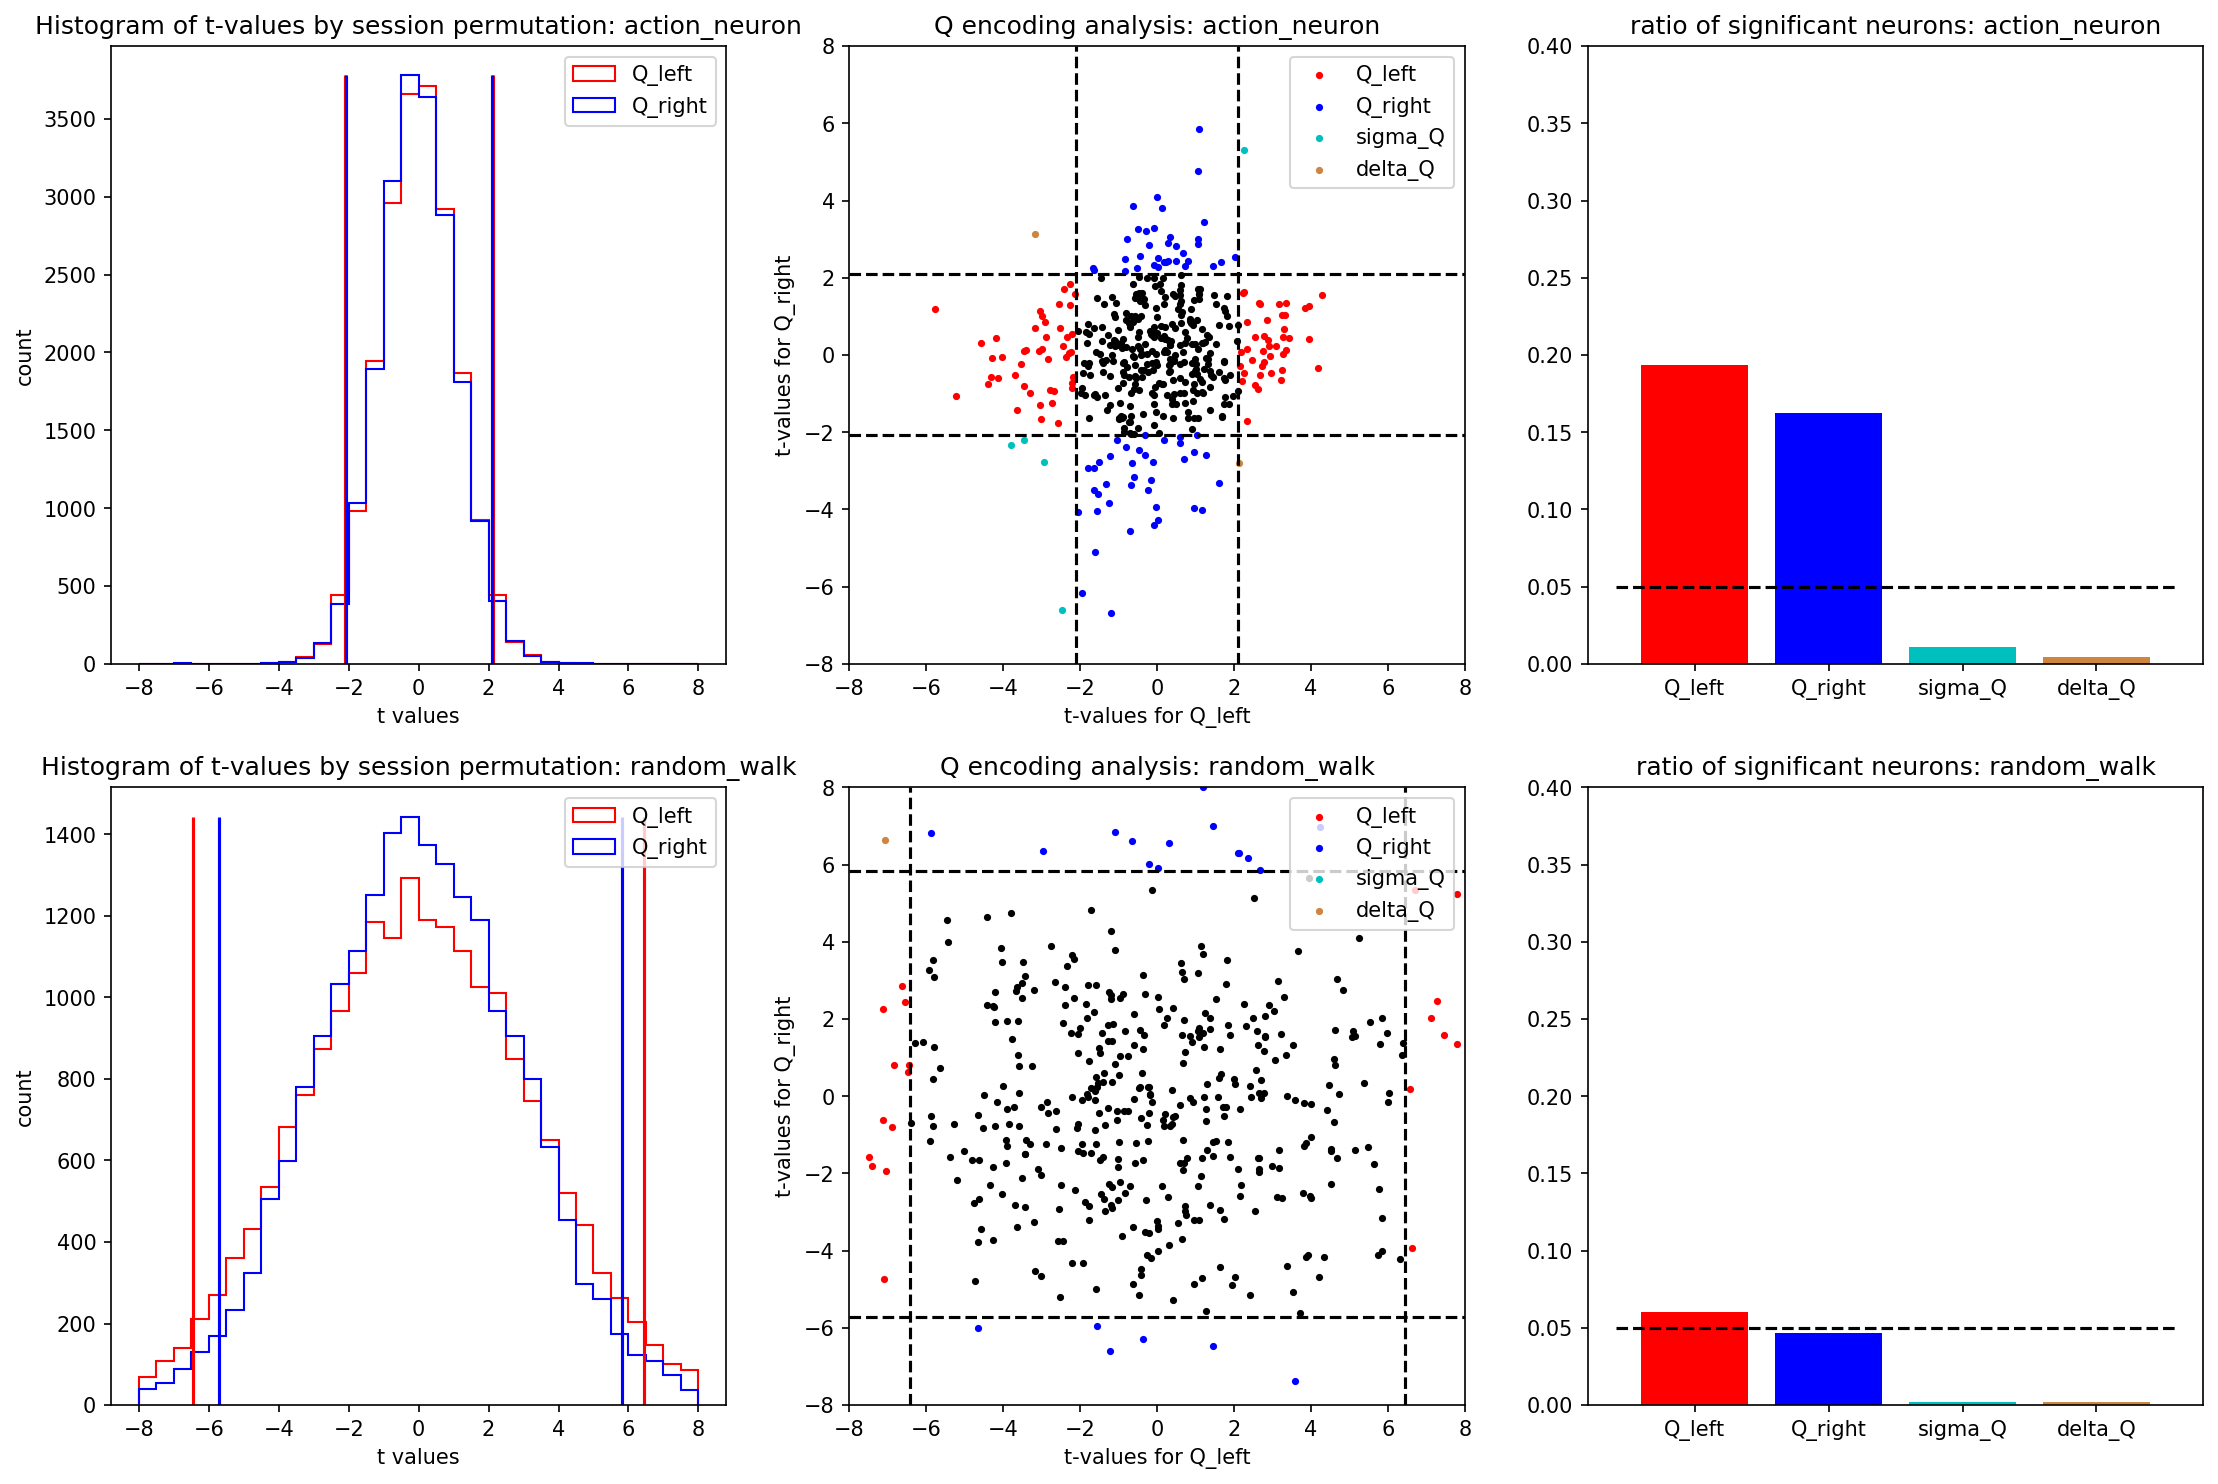

In [170]:
df_t_values_dict = {
    'action_neuron': pd.DataFrame(df_action_neuron_fit['tvalues'].values.tolist(), index=df_action_neuron_fit['tvalues'].index),
    'random_walk': pd.DataFrame(df_rw_neuron_fit['tvalues'].values.tolist(), index=df_rw_neuron_fit['tvalues'].index)
}

df_fit_dict = {
    'action_neuron': df_action_neuron_fit,
    'random_walk': df_rw_neuron_fit
}

colors = ['r', 'b', 'c', 'peru']
dot_size = 6
plot_lim = (-8, 8)

neuron_types = ['action_neuron', 'random_walk']

fig, axs = plt.subplots(2, 3, figsize=(18, 12), dpi=150)
for i, neuron_type in enumerate(neuron_types):
    df_t_values = df_t_values_dict[neuron_type]

    # calculating percentiles
    t_left = df_t_values['Q_left'].values
    t_right = df_t_values['Q_right'].values
    percentiles_2_compute = [2.5, 97.5]
    t_left_percentile = np.percentile(t_left, percentiles_2_compute)
    t_right_percentile = np.percentile(t_right, percentiles_2_compute)
    print(f'left percentile: {t_left_percentile}')
    print(f'right percentile: {t_right_percentile}')
    
    plot_xlim = (np.floor(t_left_percentile[0]), np.floor(t_left_percentile[1])+1)
    plot_ylim = (np.floor(t_right_percentile[0]), np.floor(t_right_percentile[1])+1)

    hist_left, _, _ = axs[i, 0].hist(t_left, bins=32, range=plot_lim, histtype='step', color='r', label='Q_left')
    hist_right, _, _ = axs[i, 0].hist(t_right, bins=32, range=plot_lim, histtype='step', color='b', label='Q_right')
    axs[i, 0].set_title(f'Histogram of t-values by session permutation: {neuron_type}')
    axs[i, 0].set_xlabel('t values')
    axs[i, 0].set_ylabel('count')
    top = np.max(np.concatenate((hist_left, hist_right), axis=0))
    axs[i, 0].vlines(t_left_percentile, 0, top, color='r')
    axs[i, 0].vlines(t_right_percentile, 0, top, color='b')
    axs[i, 0].legend(loc='best')

    # plot only self-fitted session
    df_fit = df_fit_dict[neuron_type]
    self_id = df_fit[df_fit['fit_session']==df_fit['session']].index
    df_t_values = df_t_values.iloc[self_id]

    # plotting
    df_t_Q_left = df_t_values[((df_t_values['Q_left']>=t_left_percentile[1]) | (df_t_values['Q_left']<=t_left_percentile[0])) & 
                              (df_t_values['Q_right']<t_right_percentile[1]) & (df_t_values['Q_right']>t_right_percentile[0])]
    axs[i, 1].scatter(df_t_Q_left['Q_left'].values, df_t_Q_left['Q_right'].values, 
                      color='r', s=dot_size, label='Q_left')
    df_t_Q_right = df_t_values[((df_t_values['Q_right']>=t_right_percentile[1]) | (df_t_values['Q_right']<=t_right_percentile[0])) & 
                              (df_t_values['Q_left']<t_left_percentile[1]) & (df_t_values['Q_left']>t_left_percentile[0])]
    axs[i, 1].scatter(df_t_Q_right['Q_left'].values, df_t_Q_right['Q_right'].values, 
                      color='b', s=dot_size, label='Q_right')
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=t_left_percentile[1]) & (df_t_values['Q_right']>=t_right_percentile[1])) | 
                            ((df_t_values['Q_left']<t_left_percentile[0]) & (df_t_values['Q_right']<t_right_percentile[0]))]
    axs[i, 1].scatter(df_t_sigma_Q['Q_left'].values, df_t_sigma_Q['Q_right'].values, 
                      color='c', s=dot_size, label='sigma_Q')
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=t_left_percentile[1]) & (df_t_values['Q_right']<t_right_percentile[0])) | 
                            ((df_t_values['Q_left']<t_left_percentile[0]) & (df_t_values['Q_right']>=t_right_percentile[1]))]
    axs[i, 1].scatter(df_t_delta_Q['Q_left'].values, df_t_delta_Q['Q_right'].values, 
                      color='peru', s=dot_size, label='delta_Q')
    df_t_null = df_t_values[(df_t_values['Q_left']<t_left_percentile[1]) & (df_t_values['Q_left']>=t_left_percentile[0]) & 
                              (df_t_values['Q_right']<t_right_percentile[1]) & (df_t_values['Q_right']>=t_right_percentile[0])]
    axs[i, 1].scatter(df_t_null['Q_left'].values, df_t_null['Q_right'].values, 
                      color='k', s=dot_size)

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    axs[i, 1].hlines(t_right_percentile, plot_lim[0], plot_lim[1], color='k', linestyle='--')
    axs[i, 1].vlines(t_left_percentile, plot_lim[0], plot_lim[1], color='k', linestyle='--')
    

    axs[i, 1].set_title(f'Q encoding analysis: {neuron_type}')
    axs[i, 1].set_xlim(plot_lim[0], plot_lim[1])
    axs[i, 1].set_ylim(plot_lim[0], plot_lim[1])
    axs[i, 1].set_xlabel('t-values for Q_left')
    axs[i, 1].set_ylabel('t-values for Q_right')
    axs[i, 1].legend()


    names = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
    print(float(len(df_t_values)))
    print(len(df_t_Q_left))
    print(len(df_t_Q_right))
    print(len(df_t_sigma_Q))
    print(len(df_t_delta_Q))
    values = [
        len(df_t_Q_left)/ float(len(df_t_values)),
        len(df_t_Q_right)/ float(len(df_t_values)),
        len(df_t_sigma_Q)/ float(len(df_t_values)),
        len(df_t_delta_Q)/ float(len(df_t_values))
    ]
    axs[i, 2].bar(names, values, color=colors)
    x_lim = axs[i, 2].get_xlim()
    axs[i, 2].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[i, 2].set_title(f'ratio of significant neurons: {neuron_type}')
    axs[i, 2].set_ylim(0, 0.4)


### Multi-session permutation method

In [5]:
# select sessions
sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

n_session_to_ana = 5
manual_selection = True
if manual_selection:
    sessions = [38, 39, 40, 42, 45]
else:
    sessions = np.random.choice(sessions_all, size=n_session_to_ana)
print(f'selected sessions for ana: {sessions}')

# get min session length
session_len = []
for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    session_len.append(len(df_Qs_session))

print(f'min session {session_len.index(min(session_len))} len: {min(session_len)}, max session {session_len.index(max(session_len))} len: {max(session_len)}')
len_min = min(session_len)

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
selected sessions for ana: [38, 39, 40, 42, 45]
min session 0 len: 468, max session 3 len: 1143


In [155]:
# generate simulated neurons
n_neurons = 500
neuron_types = ['Q_left', 'Q_right', 'rw']

sim_neuron_columns = ['session', 'neuron_id', 'firing_rates']
sim_neurons = {
    'Q_left': pd.DataFrame(columns=sim_neuron_columns),
    'Q_right': pd.DataFrame(columns=sim_neuron_columns),
    'rw': pd.DataFrame(columns=sim_neuron_columns)
}

for n in range(n_neurons):

    for gen_session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==gen_session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        print(f'session {gen_session}: {X.shape}')

        # chop the session to chunks of min len
        for i in range(int(np.floor(len(df_Qs_session)/ len_min))):
            t_start = i * len_min

            if i == 0: # remove this to treat different chunks as different sessions
                for neuron_type in neuron_types:
                    if neuron_type in ['Q_left', 'Q_right']:
                        fr = gen_action_value_neuron(X[neuron_type].values[t_start: t_start+len_min])
                    elif neuron_type == 'rw':
                        fr = gen_random_walk_neuron(len_min)
                    else:
                        raise ValueError('wrong neuron types!')
                    sim_neurons[neuron_type].loc[len(sim_neurons[neuron_type].index)] = [gen_session, n, fr]

session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
sess

In [156]:
# compute the test statistic: avg t values of regression
# in all possible permutations

fit_columns = ['neuron_id', 'gen_session_perm', 'fit_session_perm', 'tvalues_Q_left', 'tvalues_Q_right']
df_fit_dict = {
    'Q_left': pd.DataFrame(columns=fit_columns),
    'Q_right': pd.DataFrame(columns=fit_columns),
    'rw': pd.DataFrame(columns=fit_columns)
}

# single neuron, present in all sessions
for j, p in enumerate(itertools.permutations(range(len(sessions)))):
    print(f'permutation {j}: {p}')

    for n in range(n_neurons):
        for neuron_type in neuron_types:

            gen_session_perm = []
            fit_session_perm = []
            tvalues_Q_left = []
            tvalues_Q_right = []

            for session_id in range(len(sessions)):
                gen_session = sessions[session_id]
                fit_session = sessions[p[session_id]]
                gen_session_perm.append(gen_session)
                fit_session_perm.append(fit_session)
                # print(f' using gen_session {gen_session} and fit_session {fit_session}')

                # get Qs
                df_Qs_session = df_Qs[df_Qs['session']==fit_session].sort_values(by=['trial'])
                X_fit = df_Qs_session[['Q_left', 'Q_right']]
                X_fit = sm.add_constant(X_fit)
                X_fit = X_fit[:len_min]
                # print(f' session {fit_session}: {X_fit.shape}')

                fr = sim_neurons[neuron_type][(sim_neurons[neuron_type]['session']==gen_session) & 
                                              (sim_neurons[neuron_type]['neuron_id']==n)]['firing_rates'].values[0]
                model = sm.OLS(fr, X_fit)
                results = model.fit()
                tvalues_Q_left.append(results.tvalues['Q_left'])
                tvalues_Q_right.append(results.tvalues['Q_right'])

            tvalues_Q_left = np.array(tvalues_Q_left)
            tvalues_Q_right = np.array(tvalues_Q_right)
            df_fit_dict[neuron_type].loc[len(df_fit_dict[neuron_type].index)] = [n,  gen_session_perm, fit_session_perm, 
                                                                                 tvalues_Q_left, tvalues_Q_right]

permutation 0: (0, 1, 2, 3, 4)
permutation 1: (0, 1, 2, 4, 3)
permutation 2: (0, 1, 3, 2, 4)
permutation 3: (0, 1, 3, 4, 2)
permutation 4: (0, 1, 4, 2, 3)
permutation 5: (0, 1, 4, 3, 2)
permutation 6: (0, 2, 1, 3, 4)
permutation 7: (0, 2, 1, 4, 3)
permutation 8: (0, 2, 3, 1, 4)
permutation 9: (0, 2, 3, 4, 1)
permutation 10: (0, 2, 4, 1, 3)
permutation 11: (0, 2, 4, 3, 1)
permutation 12: (0, 3, 1, 2, 4)
permutation 13: (0, 3, 1, 4, 2)
permutation 14: (0, 3, 2, 1, 4)
permutation 15: (0, 3, 2, 4, 1)
permutation 16: (0, 3, 4, 1, 2)
permutation 17: (0, 3, 4, 2, 1)
permutation 18: (0, 4, 1, 2, 3)
permutation 19: (0, 4, 1, 3, 2)
permutation 20: (0, 4, 2, 1, 3)
permutation 21: (0, 4, 2, 3, 1)
permutation 22: (0, 4, 3, 1, 2)
permutation 23: (0, 4, 3, 2, 1)
permutation 24: (1, 0, 2, 3, 4)
permutation 25: (1, 0, 2, 4, 3)
permutation 26: (1, 0, 3, 2, 4)
permutation 27: (1, 0, 3, 4, 2)
permutation 28: (1, 0, 4, 2, 3)
permutation 29: (1, 0, 4, 3, 2)
permutation 30: (1, 2, 0, 3, 4)
permutation 31: (1

check sum of dots: 513
500.0
99
23
2
1
check sum of dots: 512
500.0
24
102
3
0
check sum of dots: 506
500.0
33
23
8
0


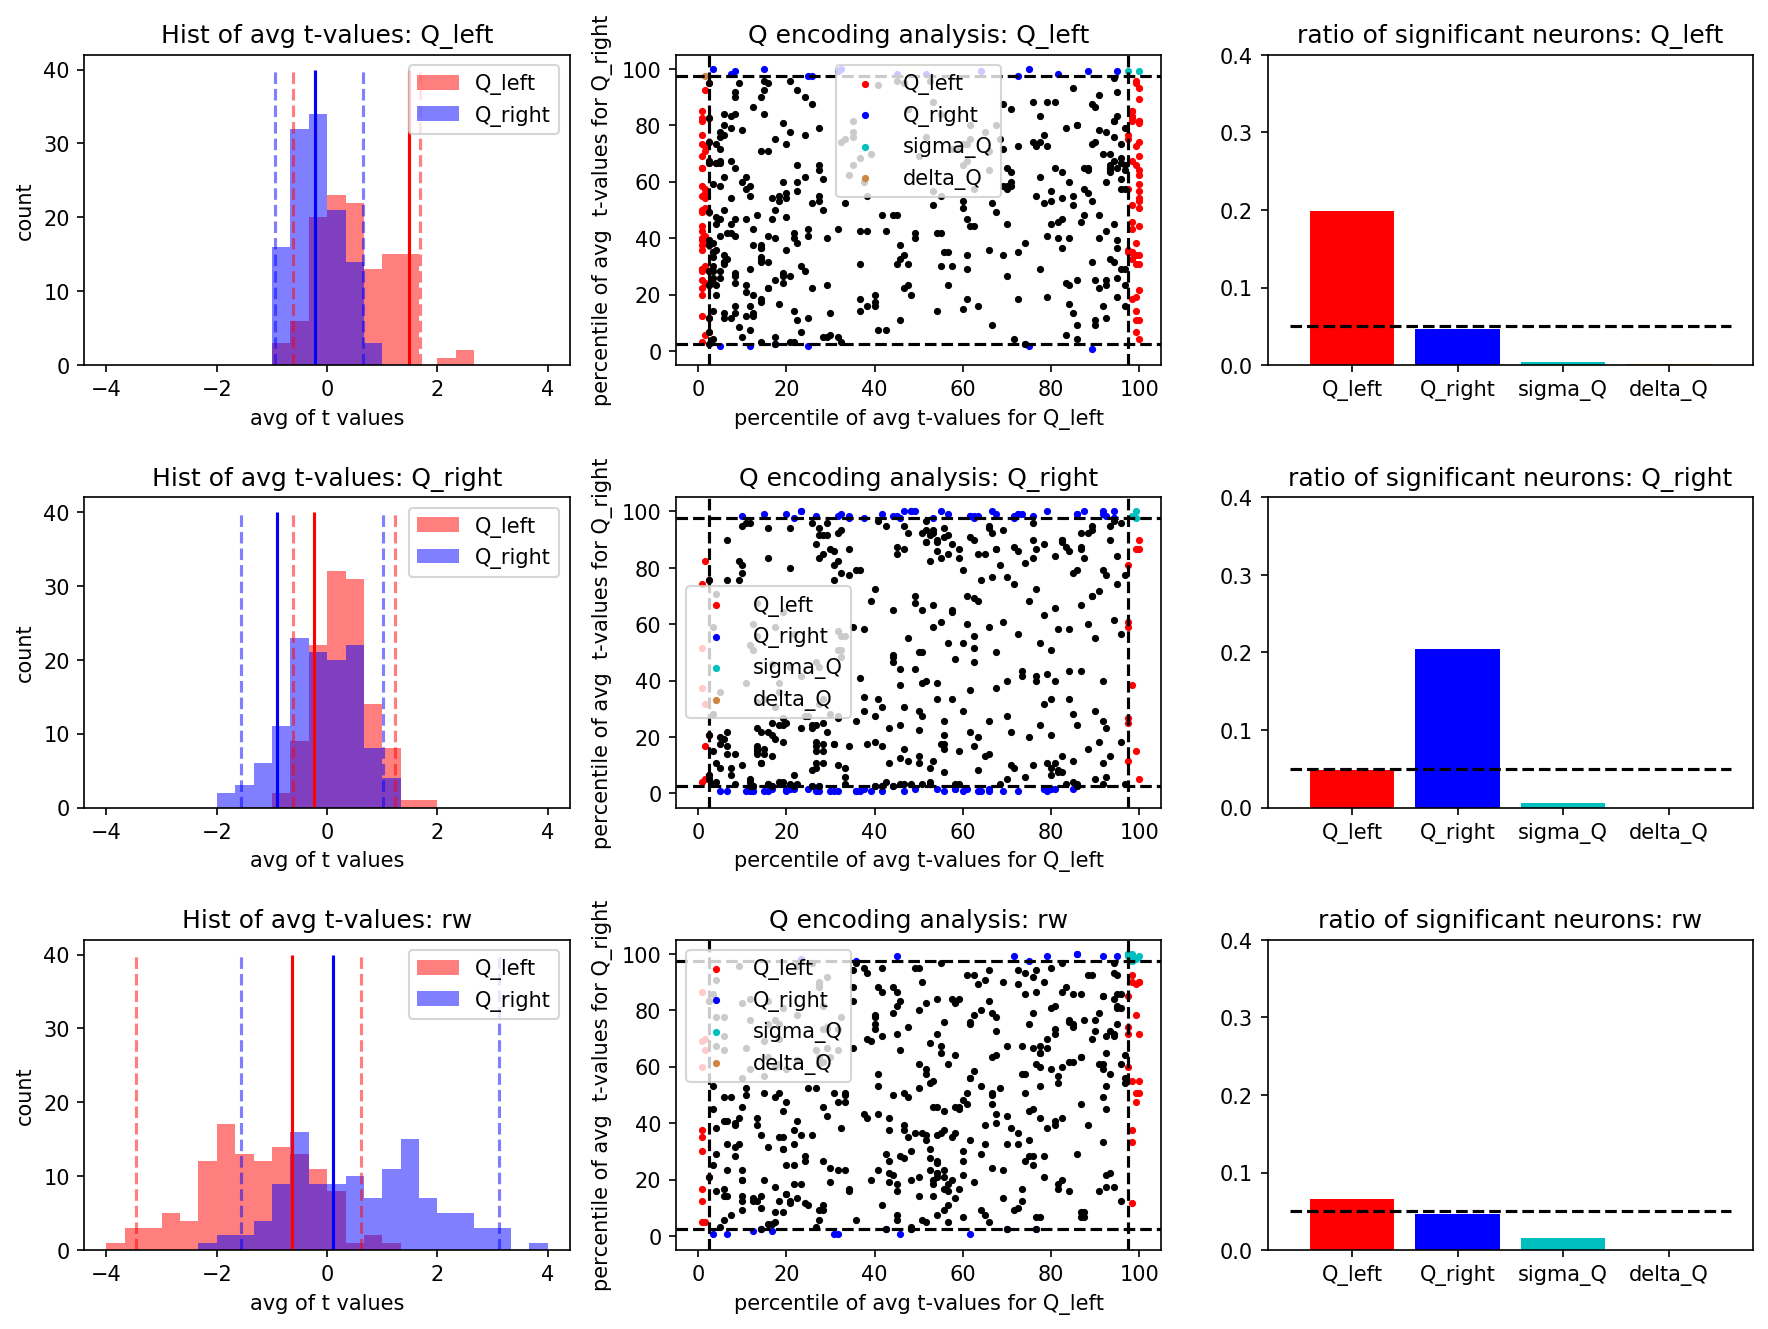

In [157]:
plot_lim = (-4, 4)
hist_top = 40
colors = {'Q_left': 'r', 'Q_right': 'b'}
bar_colors = ['r', 'b', 'c', 'peru']
dot_size = 6

neuron_ind_to_plot_hist = 0

fig, axs = plt.subplots(len(neuron_types), 3, figsize=(12, 3*len(neuron_types)), dpi=150)
for row_ind, neuron_type in enumerate(neuron_types):
    df_fit = df_fit_dict[neuron_type]
    
    # plot histogram for one neuron
    for i, q_side in enumerate(['Q_left', 'Q_right']):
        df_fit_hist = df_fit[df_fit['neuron_id']==neuron_ind_to_plot_hist] # only plot hist of one neuron
        t_values_q_side = np.vstack(df_fit_hist[f'tvalues_{q_side}'].values[:]).astype(np.float)
        avg_t_q_side = np.average(t_values_q_side, axis=1)
        percentiles_2_compute = [2.5, 97.5]
        avg_t_percentile_q_side = np.percentile(avg_t_q_side, percentiles_2_compute)

        # self fitted permutation
        self_q_side = df_fit_hist[df_fit_hist['gen_session_perm']==df_fit_hist['fit_session_perm']][f'tvalues_{q_side}'].iloc[0]
        avg_self_q_side = np.average(self_q_side)

        hist_q_side, _, _ = axs[row_ind, 0].hist(avg_t_q_side, bins=24, range=plot_lim, histtype='stepfilled', 
                                                 color=colors[q_side], label=q_side, alpha=0.5)
        axs[row_ind, 0].vlines(avg_t_percentile_q_side, 0, hist_top, 
                                color=colors[q_side], linestyle='--', alpha=0.5)
        axs[row_ind, 0].vlines(avg_self_q_side, 0, hist_top, color=colors[q_side])

    axs[row_ind, 0].set_title(f'Hist of avg t-values: {neuron_type}')
    axs[row_ind, 0].set_xlabel('avg of t values')
    axs[row_ind, 0].set_ylabel('count')
    axs[row_ind, 0].legend()


    # scatter plot of neurons
    df_avg_t_percentile = pd.DataFrame(columns=['Q_left', 'Q_right'])
    for n in range(n_neurons):
        df_fit_neuron = df_fit[df_fit['neuron_id']==n]
        row = []
        for i, q_side in enumerate(['Q_left', 'Q_right']):
            tvalues_q_side = np.vstack(df_fit_neuron[f'tvalues_{q_side}'].values[:]).astype(np.float)
            avg_tvalues_q_side = np.average(tvalues_q_side, axis=1)
            
            # self fitted permutation
            tvalue_self_q_side = df_fit_neuron[df_fit_neuron['gen_session_perm']==df_fit_neuron['fit_session_perm']][f'tvalues_{q_side}'].iloc[0]
            avg_tvalue_self_q_side = np.average(tvalue_self_q_side)
            row.append(stats.percentileofscore(avg_tvalues_q_side, avg_tvalue_self_q_side))
        df_avg_t_percentile.loc[len(df_avg_t_percentile.index)] = row

    df_t_Q_left = df_avg_t_percentile[((df_avg_t_percentile['Q_left']>=97.5) | (df_avg_t_percentile['Q_left']<=2.5)) & 
                                      (df_avg_t_percentile['Q_right']<97.5) & (df_avg_t_percentile['Q_right']>2.5)]
    axs[row_ind, 1].scatter(df_t_Q_left['Q_left'].values, df_t_Q_left['Q_right'].values, 
                            color='r', s=dot_size, label='Q_left')
    df_t_Q_right = df_avg_t_percentile[((df_avg_t_percentile['Q_right']>=97.5) | (df_avg_t_percentile['Q_right']<=2.5)) & 
                                       (df_avg_t_percentile['Q_left']<97.5) & (df_avg_t_percentile['Q_left']>2.5)]
    axs[row_ind, 1].scatter(df_t_Q_right['Q_left'].values, df_t_Q_right['Q_right'].values, 
                            color='b', s=dot_size, label='Q_right')
    df_t_sigma_Q = df_avg_t_percentile[((df_avg_t_percentile['Q_left']>=97.5) & (df_avg_t_percentile['Q_right']>=97.5)) | 
                                       ((df_avg_t_percentile['Q_left']<2.5) & (df_avg_t_percentile['Q_right']<2.5))]
    axs[row_ind, 1].scatter(df_t_sigma_Q['Q_left'].values, df_t_sigma_Q['Q_right'].values, 
                            color='c', s=dot_size, label='sigma_Q')
    df_t_delta_Q = df_avg_t_percentile[((df_avg_t_percentile['Q_left']>=97.5) & (df_avg_t_percentile['Q_right']<2.5)) | 
                                       ((df_avg_t_percentile['Q_left']<2.5) & (df_avg_t_percentile['Q_right']>=97.5))]
    axs[row_ind, 1].scatter(df_t_delta_Q['Q_left'].values, df_t_delta_Q['Q_right'].values, 
                            color='peru', s=dot_size, label='delta_Q')
    df_t_null = df_avg_t_percentile[(df_avg_t_percentile['Q_left']<97.5) & (df_avg_t_percentile['Q_left']>=2.5) & 
                                    (df_avg_t_percentile['Q_right']<97.5) & (df_avg_t_percentile['Q_right']>=2.5)]
    axs[row_ind, 1].scatter(df_t_null['Q_left'].values, df_t_null['Q_right'].values, 
                            color='k', s=dot_size)

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    axs[row_ind, 1].hlines([2.5, 97.5], -5, 105, color='k', linestyle='--')
    axs[row_ind, 1].vlines([2.5, 97.5], -5, 105, color='k', linestyle='--')
    axs[row_ind, 1].set_title(f'Q encoding analysis: {neuron_type}')
    axs[row_ind, 1].set_xlim(-5, 105)
    axs[row_ind, 1].set_ylim(-5, 105)
    axs[row_ind, 1].set_xlabel('percentile of avg t-values for Q_left')
    axs[row_ind, 1].set_ylabel('percentile of avg  t-values for Q_right')
    axs[row_ind, 1].legend()

    # bar plot for significant neurons
    names = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
    print(float(len(df_avg_t_percentile)))
    print(len(df_t_Q_left))
    print(len(df_t_Q_right))
    print(len(df_t_sigma_Q))
    print(len(df_t_delta_Q))
    values = [
        len(df_t_Q_left)/ float(len(df_avg_t_percentile)),
        len(df_t_Q_right)/ float(len(df_avg_t_percentile)),
        len(df_t_sigma_Q)/ float(len(df_avg_t_percentile)),
        len(df_t_delta_Q)/ float(len(df_avg_t_percentile))
    ]
    axs[row_ind, 2].bar(names, values, color=bar_colors)
    x_lim = axs[row_ind, 2].get_xlim()
    axs[row_ind, 2].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, 2].set_title(f'ratio of significant neurons: {neuron_type}')
    axs[row_ind, 2].set_ylim(0, 0.4)

plt.tight_layout()